In [1]:
import numpy as np

class Perceptron(object):
    '''
    (매개변수)
    eta : float
        학습률 (0.0과 1.0사이의 float)
    n_iter : int 
        훈련 데이터셋 반복 횟수
    random_state : int
        가중치 무작위 초기화를 위한 난수 생성기 시드
        
    (속성)
    w_ : 1d-array
        학습된 가중치
    errors_ : list
        에포크마다 누적된 분류 오류
    '''
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y): #모델을 훈련하는 메소드
        '''
        (매개변수)
        x : n_sample개의 샘플(행)과 n_feature개의 특성(열)으로 이루어진
        훈련 데이터 
        y: 타깃값 (1차원 배열)

        (return)
        self: object
        '''
        rgen = np.random.RandomState(self.random_state) # 난수 발생기 초기화
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size= 1 + X.shape[1]) #0~1사이의 난수 발생(개수는 특성보다 하나 많게, 절편때문)

        self.errors_ = [] #오차값 저장을 위한 빈 list

        for _ in range(self.n_iter): #얘는 eta를 먼저 적용
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi)) #실제 값과 예측 값(yhat)을 이용해서 업데이트 값을 만듬
                self.w_[1:] += update * xi #업데이트 함
                self.w_[0:] += update #절편은 1이었으니까 1을 곱하나 마나여서 그냥 안 씀.. x0가 없으니
                errors += int(update != 0.0) #타깃을 정확히 맞추지 못 한 경우를 센다
            self.errors_.append(errors) #에러리스트에 추가해 에포크마다 에러의 증감을 살핌
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0] #dot를 이용해 점곱을 사용함. 절편 제외 점곱 하고 절편은 따로 계산

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1) #퍼셉트론 결정함수

In [2]:
#붓꽃 데이터셋 퍼셉트론 훈련

import os
import pandas as pd
s = os.path.join('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
print('URL: ', s)
df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail() #마지막 셀

URL:  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


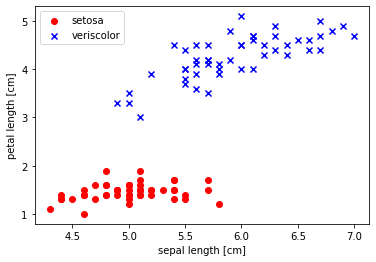

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

y = df.iloc[0:100, 4].values
y = np.where(y == "Iris-setosa", -1, 1)

#꽃받침 길이와 꽃입 길이 추출
X = df.iloc[0:100, [0, 2]].values

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='veriscolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

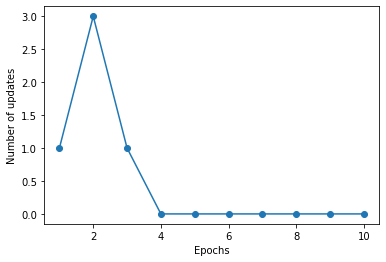

In [4]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.show()

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_resions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #결정 경계 그리기
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), #2차원 평면의 모든 좌표의 값을 표현해줌
                          np.arange(x2_min, x2_max, resolution)) #resolution은 간격(0.02라 엄청 촘촘함) -> 색칠처럼 보임!
    
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   label=cl,
                   edgecolor='black')

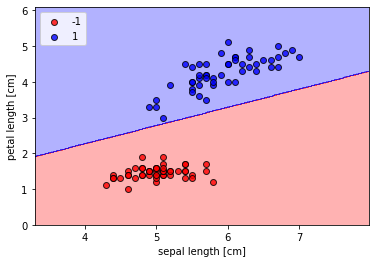

In [6]:
plot_decision_resions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

In [7]:
class AdalineGD(object):
    """적응형 선형 뉴런 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : array-like, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # 이 코드의 활성화 함수는 항등 함수(identity function)이기 때문에
            # 아무런 효과가 없습니다.
            # 이 대신 `output = self.net_input(X)`로 바로 쓸 수 있습니다.
            # 이 활성화 함수는 개념적인 목적을 위해 만들었습니다.
            # (잠시 후에 보게 될) 로지스틱 회귀의 경우 이 함수를 시그모이드 함수로 
            # 바꾸어 로지스틱 회귀 분류기를 구현합니다.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
    

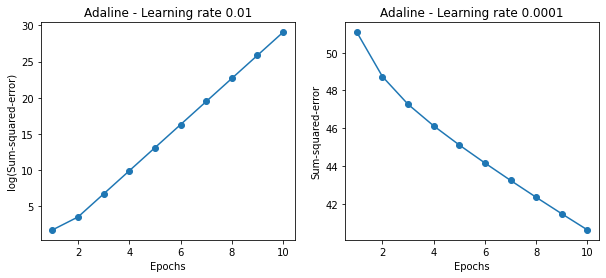

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

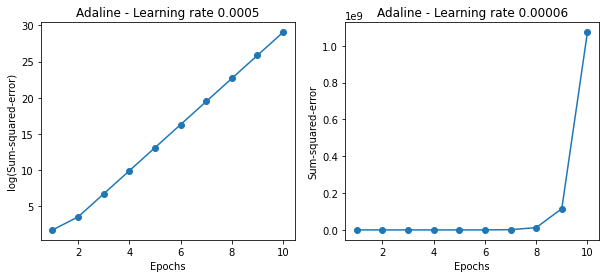

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.0005')

ada2 = AdalineGD(n_iter=10, eta=0.001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.00006')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

In [10]:
import numpy as np

class Perceptron(object):
    '''
    (매개변수)
    eta : float
        학습률 (0.0과 1.0사이의 float)
    n_iter : int 
        훈련 데이터셋 반복 횟수
    random_state : int
        가중치 무작위 초기화를 위한 난수 생성기 시드
        
    (속성)
    w_ : 1d-array
        학습된 가중치
    errors_ : list
        에포크마다 누적된 분류 오류
    '''
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y): 
        '''
        (매개변수)
        x : n_sample개의 샘플(행)과 n_feature개의 특성(열)으로 이루어진
        훈련 데이터 
        y: 타깃값 (1차원 배열)

        (return)
        self: object
        '''
        rgen = np.random.RandomState(self.random_state) 
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size= 1 + X.shape[1])

        self.errors_ = [] 

        for _ in range(self.n_iter): 
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi)) 
                self.w_[1:] += update * xi 
                self.w_[0:] += update 
                errors += int(update != 0.0) 
            self.errors_.append(errors) 
        return self

    def net_input(self, X):
        '''입력 계산'''
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        '''단위 계단 함수를 사용하여 클래스 레이블을 반환'''
        return np.where(self.net_input(X) >= 0.0, 1, -1) 